In [ ]:
! pip install concise

# Regulatory Genomics Lecture Exercise

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import concise
import concise.layers as cl
import concise.initializers as ci
import concise.regularizers as cr
import concise.metrics as cm
from concise.preprocessing import encodeDNA, encodeSplines
from concise.utils import PWM

from concise.utils.plot import seqlogo, seqlogo_fig

/opt/modules/i12g/anaconda/3-5.0.1/envs/splicing/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Used additional packages
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

## required keras modules
from keras.models import Model, load_model, Sequential
import keras.layers as kl
import keras.optimizers as ko

## Load simulated data

The simulated data contains one-hot-encoded DNA sequence, with protein binding motifs embedded.

In [4]:
!wget 'https://github.com/kundajelab/dragonn/raw/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz'

--2018-06-28 13:25:27--  https://github.com/kundajelab/dragonn/raw/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/dragonn/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz [following]
--2018-06-28 13:25:28--  https://raw.githubusercontent.com/kundajelab/dragonn/master/paper_supplement/simulation_data/GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [5]:
import numpy as np

def load_simulated_data(path):
    """Load the simulated dataset
    
    Args:
      path: path to the .npz file c
    """
    data = np.load(path)

    x_train = data["X_train"].squeeze(1).swapaxes(1,2)
    x_valid = data["X_valid"].squeeze(1).swapaxes(1,2)
    y_train = data['y_train']
    y_valid = data['y_valid']
    return (x_train, y_train), (x_valid, y_valid)

In [6]:
(x_train, y_train), (x_test, y_test) = load_simulated_data("GC_fraction0.4motif_nameTAL1_known4num_neg10000num_pos10000seq_length500.npz")

In [7]:
x_train.shape

(12800, 500, 4)

## Load TAL1 motif PWM

Get PWM of TAL1 motif

In [8]:
! wget https://github.com/s6juncheng/SystemGeneticsDL/raw/master/TAL1_known4.npy

--2018-06-28 13:25:32--  https://github.com/s6juncheng/SystemGeneticsDL/raw/master/TAL1_known4.npy
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/s6juncheng/SystemGeneticsDL/master/TAL1_known4.npy [following]
--2018-06-28 13:25:33--  https://raw.githubusercontent.com/s6juncheng/SystemGeneticsDL/master/TAL1_known4.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448 [application/octet-stream]
Saving to: ‘TAL1_known4.npy.1’

100%[======================================>] 448         --.-K/s   in 0s      

2018-06-28 13:25:33 (30.4 MB/s) - ‘TAL1_known4.npy.1’ saved [448/448]



In [9]:
# import cresim
# pwm = cresim.cre.Cre.loadPWM('TAL1_known3').pwm.getRows()

In [10]:
pwm = np.load("TAL1_known4.npy")

TAL1 motif:
![TAL1 known4](http://compbio.mit.edu/encode-motifs/logos/table/logos/small/rev/TAL1_known4.png)

## Predict binding with pwm scan model

In [36]:
# A naiv version
def pwm_scan(sequence, pwm, pad=0, stride=1):
    """ sequence: (N, L, 4)
    output length given by L' = 1 + (L + 2*P - F) / stride
    """
    assert len(sequence.shape) == 3
    assert pwm.shape[1] == 4
    N, L, _ = sequence.shape
    F, _ = pwm.shape
    S = stride
    assert (L + 2 * pad - F) % S == 0, "Size not fit."
    L_out = int(1 + (L + 2 * pad - F) / S)
    out = np.zeros((N, L_out))

    x_pad = np.pad(sequence, ((0, 0), (1, 1), (0,0)), mode='constant')

    for i in range(N):
        seq = sequence[i]
        for j in range(L_out):
            seq_patch = seq[(j * S):(j * S + F)]
            out[i, j] = np.dot(seq_patch.flatten(), pwm.flatten())

    return out

In [37]:
scores = pwm_scan(x_test, pwm)

In [13]:
scores.shape

(3200, 485)

Try two pooling strategies:
  * GloabalAveragePooling: Take average score per sequence 
  * GloabalMaxPooling: take max activation score

### Averange Pooling

In [14]:
mean_scores = scores.mean(axis=1)

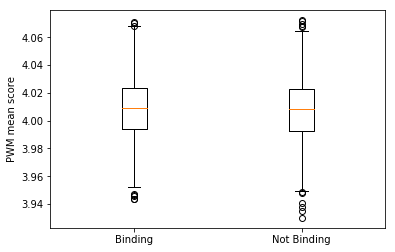

In [15]:
plt.boxplot([mean_scores[y_test.flatten()], mean_scores[~y_test.flatten()]], labels=['Binding','Not Binding'])
plt.ylabel("PWM mean score")
plt.show()

### Max Pooling

In [16]:
max_scores = scores.max(axis=1)

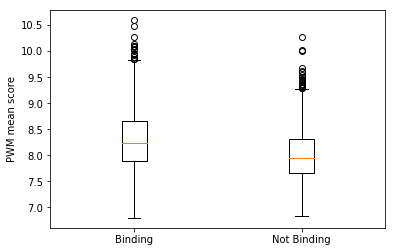

In [17]:
plt.boxplot([max_scores[y_test.flatten()], max_scores[~y_test.flatten()]], labels=['Binding','Not Binding'])
plt.ylabel("PWM mean score")
plt.show()

### Check performance

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

In [19]:
roc = {}
roc['mean_roc'] = roc_auc_score(y_test, mean_scores)
roc['max_roc'] = roc_auc_score(y_test, max_scores)

In [20]:
fpr = {}
tpr = {}
fpr['Mean'], tpr["Mean"], _ = roc_curve(y_test, mean_scores)
fpr['Max'], tpr["Max"], _ = roc_curve(y_test, max_scores)

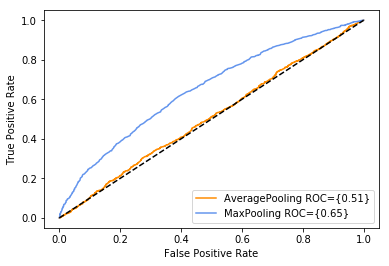

In [21]:
plt.plot(fpr['Mean'], tpr["Mean"], color='darkorange', 
        label = 'AveragePooling ROC={%0.2f}' % roc['mean_roc'])
plt.plot(fpr['Max'], tpr["Max"], color='cornflowerblue', 
        label = 'MaxPooling ROC={%0.2f}' % roc['max_roc'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Build a convolutional neural network

### Build a Sequential model
https://keras.io/getting-started/sequential-model-guide/

In [22]:
model = Sequential()
# Add one convolution layer, Conv1D
model.add(cl.ConvDNA(filters=1,
                    kernel_size=15,
                    activation='relu',
                    input_shape=(500, 4), # shape: Length sequence, 4nt
                    name='convDNA'))
model.add(kl.GlobalMaxPooling1D())
model.add(kl.Activation('sigmoid'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convDNA (ConvDNA)            (None, 486, 1)            61        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1)                 0         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer="adam", loss="binary_crossentropy")

from keras.callbacks import EarlyStopping

model.fit(x=x_train, y=y_train, epochs=300, verbose=2,
          callbacks=[EarlyStopping(patience=3)],
          validation_split=.2
         )

Train on 10240 samples, validate on 2560 samples
Epoch 1/300
 - 8s - loss: 0.7150 - val_loss: 0.6919
Epoch 2/300
 - 6s - loss: 0.6800 - val_loss: 0.6555
Epoch 3/300
 - 7s - loss: 0.6215 - val_loss: 0.6084
Epoch 4/300
 - 7s - loss: 0.5926 - val_loss: 0.5900
Epoch 5/300
 - 7s - loss: 0.5765 - val_loss: 0.5771
Epoch 6/300
 - 6s - loss: 0.5641 - val_loss: 0.5668
Epoch 7/300
 - 7s - loss: 0.5541 - val_loss: 0.5585
Epoch 8/300
 - 7s - loss: 0.5461 - val_loss: 0.5514
Epoch 9/300
 - 6s - loss: 0.5392 - val_loss: 0.5456
Epoch 10/300
 - 7s - loss: 0.5332 - val_loss: 0.5403
Epoch 11/300
 - 6s - loss: 0.5281 - val_loss: 0.5357
Epoch 12/300
 - 7s - loss: 0.5237 - val_loss: 0.5320
Epoch 13/300
 - 6s - loss: 0.5197 - val_loss: 0.5290
Epoch 14/300
 - 6s - loss: 0.5163 - val_loss: 0.5257
Epoch 15/300
 - 3s - loss: 0.5134 - val_loss: 0.5237
Epoch 16/300
 - 3s - loss: 0.5107 - val_loss: 0.5209
Epoch 17/300
 - 3s - loss: 0.5084 - val_loss: 0.5183
Epoch 18/300
 - 3s - loss: 0.5063 - val_loss: 0.5164
Epoch 

In [25]:
model.layers[0]

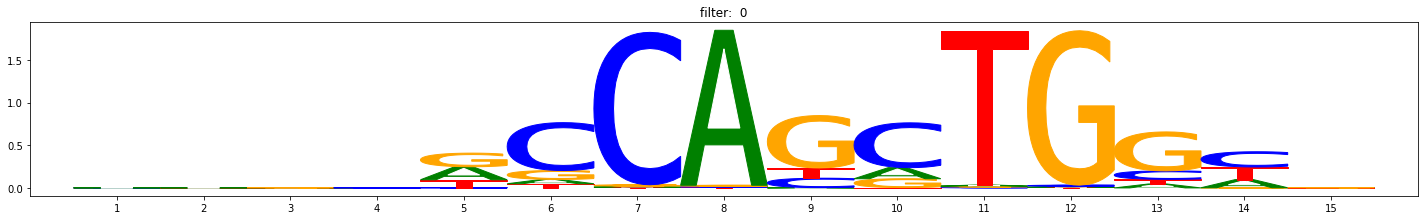

<Figure size 1440x216 with 0 Axes>

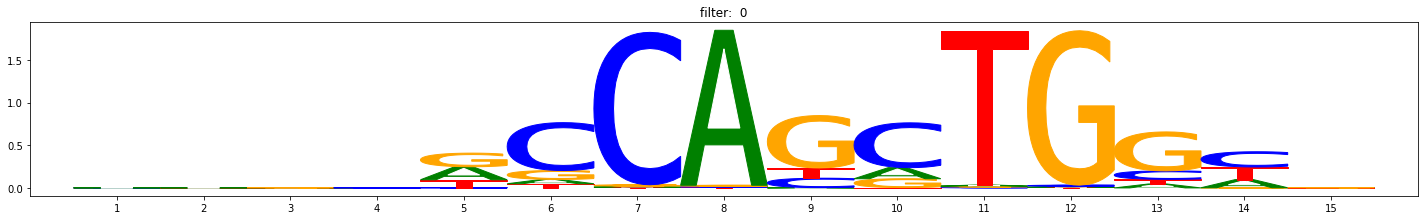

In [26]:
model.layers[0].plot_weights(figsize=(20, 3), plot_type="motif_pwm_info")

In [27]:
y_test_pred = model.predict(x_test)

roc['ConvNet1Motif'] = roc_auc_score(y_test, y_test_pred)

In [28]:
fpr['ConvNet1Motif'], tpr["ConvNet1Motif"], _ = roc_curve(y_test, y_test_pred)

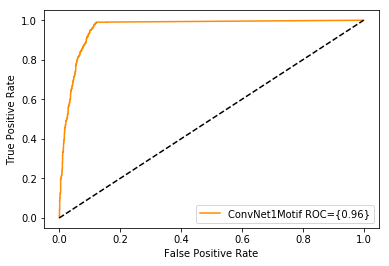

In [29]:
plt.plot(fpr['ConvNet1Motif'], tpr["ConvNet1Motif"], color='darkorange', 
        label = 'ConvNet1Motif ROC={%0.2f}' % roc['ConvNet1Motif'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Build a model with functional API
https://keras.io/getting-started/functional-api-guide/

In [30]:
inputs = kl.Input(shape=(500,4))
x = cl.ConvDNA(filters=4,
                kernel_size=15,
                activation='relu',
                name='convDNA')(inputs)
x = kl.GlobalMaxPooling1D()(x)
x = kl.Dense(1, name='dense')(x)
x = kl.Activation('sigmoid')(x)

model = Model(inputs=inputs, outputs=x)

In [31]:
model.compile(optimizer="adam", loss="binary_crossentropy")

from keras.callbacks import EarlyStopping

model.fit(x=x_train, y=y_train, epochs=300, verbose=2,
          callbacks=[EarlyStopping(patience=3)],
          validation_split=.2
         )

Train on 10240 samples, validate on 2560 samples
Epoch 1/300
 - 4s - loss: 0.7007 - val_loss: 0.7059
Epoch 2/300
 - 5s - loss: 0.6961 - val_loss: 0.6997
Epoch 3/300
 - 4s - loss: 0.6933 - val_loss: 0.6997
Epoch 4/300
 - 5s - loss: 0.6860 - val_loss: 0.6754
Epoch 5/300
 - 5s - loss: 0.6388 - val_loss: 0.6192
Epoch 6/300
 - 5s - loss: 0.5882 - val_loss: 0.5672
Epoch 7/300
 - 5s - loss: 0.5354 - val_loss: 0.5129
Epoch 8/300
 - 5s - loss: 0.4854 - val_loss: 0.4656
Epoch 9/300
 - 5s - loss: 0.4437 - val_loss: 0.4282
Epoch 10/300
 - 5s - loss: 0.4123 - val_loss: 0.3999
Epoch 11/300
 - 5s - loss: 0.3886 - val_loss: 0.3813
Epoch 12/300
 - 6s - loss: 0.3709 - val_loss: 0.3678
Epoch 13/300
 - 5s - loss: 0.3584 - val_loss: 0.3543
Epoch 14/300
 - 6s - loss: 0.3495 - val_loss: 0.3462
Epoch 15/300
 - 5s - loss: 0.3421 - val_loss: 0.3406
Epoch 16/300
 - 5s - loss: 0.3377 - val_loss: 0.3364
Epoch 17/300
 - 5s - loss: 0.3332 - val_loss: 0.3333
Epoch 18/300
 - 6s - loss: 0.3306 - val_loss: 0.3312
Epoch 

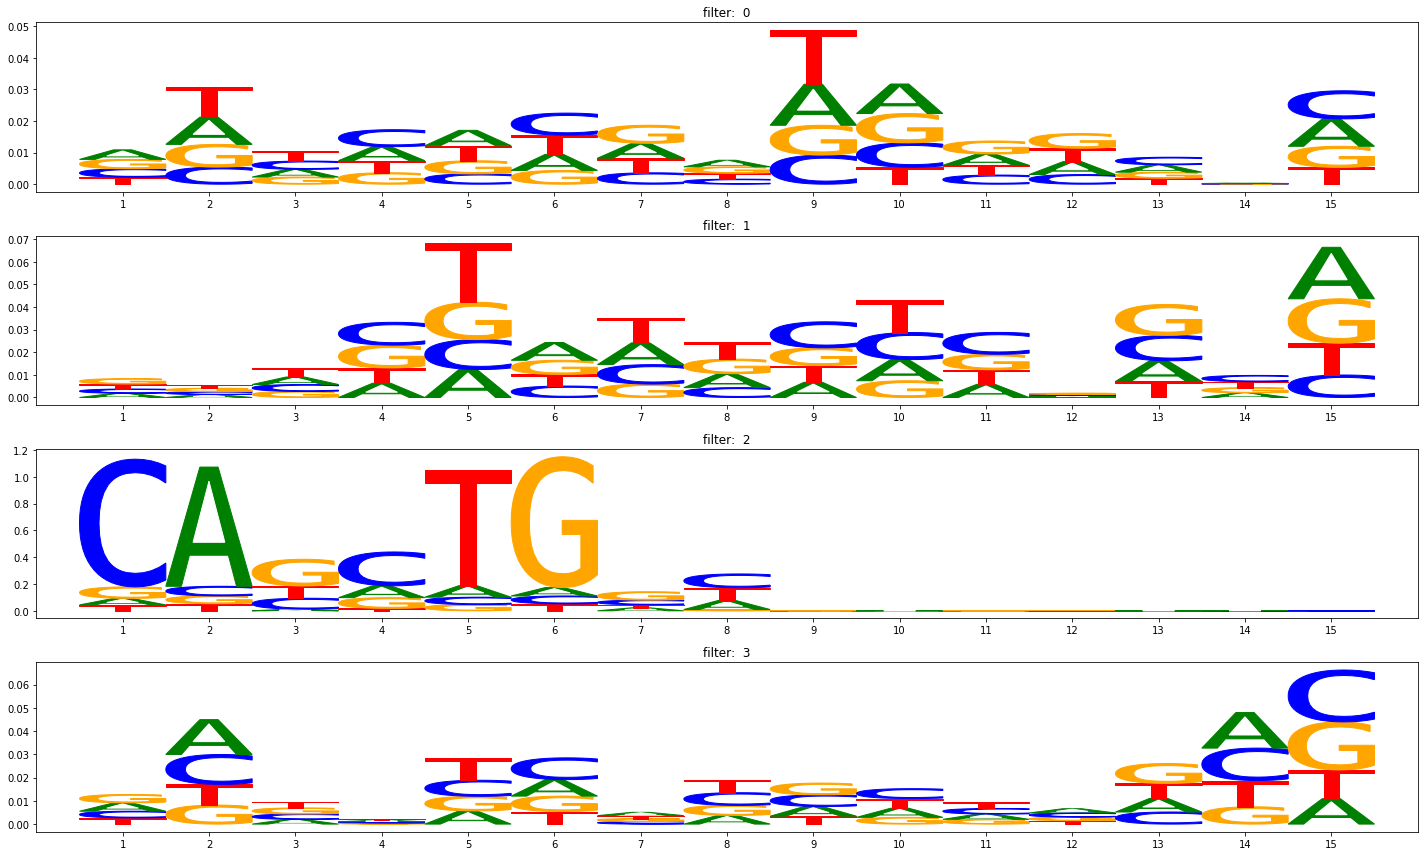

<Figure size 1440x864 with 0 Axes>

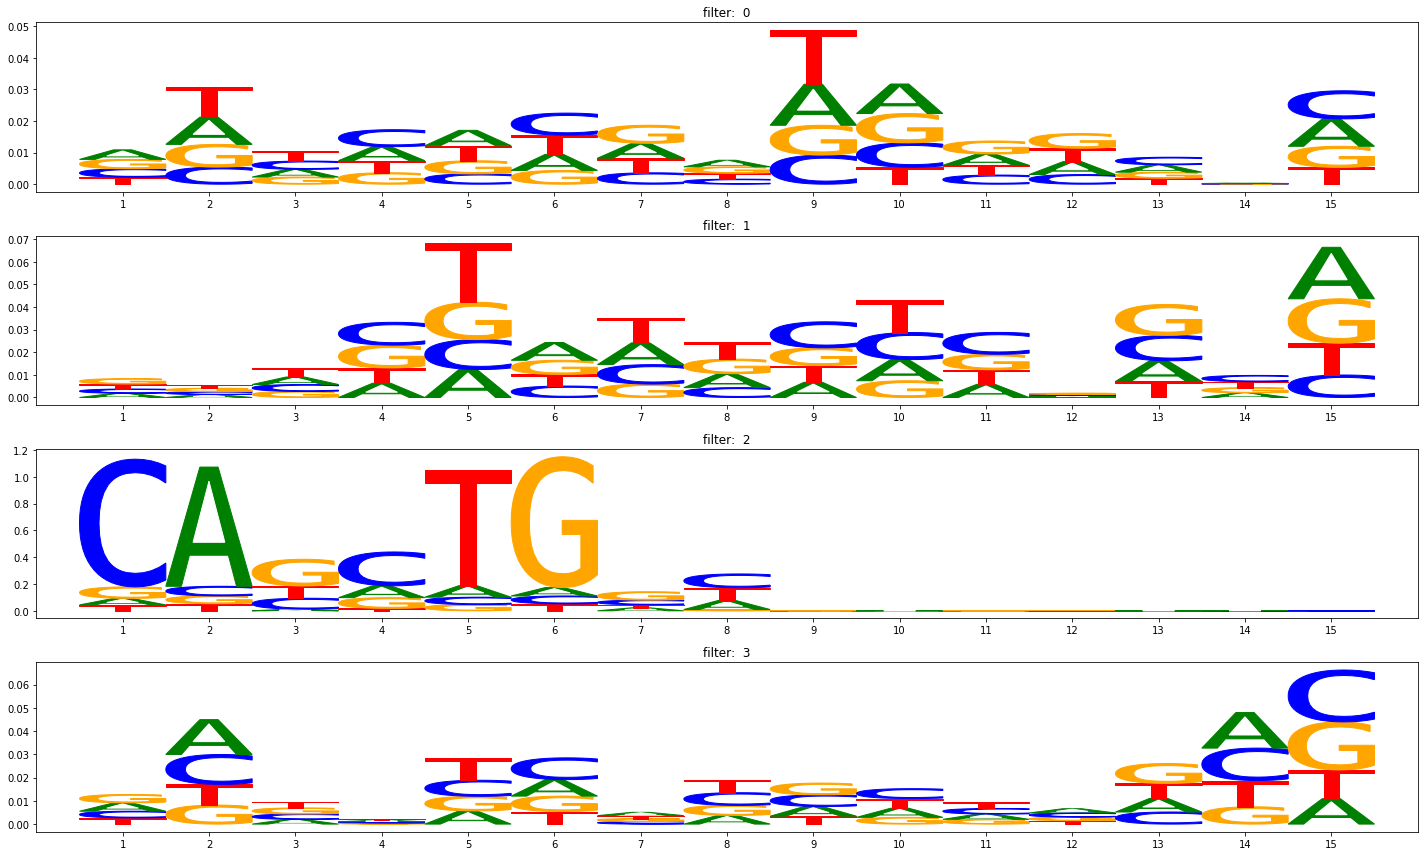

In [32]:
model.layers[1].plot_weights(figsize=(20, 12), plot_type="motif_pwm_info")

In [33]:
y_test_pred = model.predict(x_test)

roc['ConvNet16Motif'] = roc_auc_score(y_test, y_test_pred)

In [34]:
fpr['ConvNet16Motif'], tpr["ConvNet16Motif"], _ = roc_curve(y_test, y_test_pred)

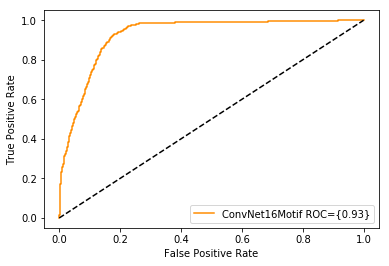

In [35]:
plt.plot(fpr['ConvNet16Motif'], tpr["ConvNet16Motif"], color='darkorange', 
        label = 'ConvNet16Motif ROC={%0.2f}' % roc['ConvNet16Motif'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()